# Compile Observation Statistics

I want to compile a bunch of information about each observation for the eventual table in my paper. Things to compile:

- Star
- RA/DEC
- UT date
- Julian Date
- Observation Time
- S/N ratio

I will also put together the other tables in this notebook:

- Primary star parameters
- Companion parameters

In [60]:
import os
from astropy.io import fits
import HelperFunctions
import glob
import h5py
import logging
import numpy as np
import pandas as pd
from astropy.time import Time
from collections import defaultdict
import Priors

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
home = os.environ['HOME']
basedir = os.path.join(home, 'School', 'Research')

inst_dirs = dict(TS23=os.path.join(basedir, 'McDonaldData'),
                 HRS=os.path.join(basedir, 'HET_data'),
                 CHIRON=os.path.join(basedir, 'CHIRON_data'),
                 IGRINS=os.path.join(basedir, 'IGRINS_data'))

In [ ]:
inst_file_lists = {}
for inst in inst_dirs.keys():
    file_list = []
    logging.info('Instrument: {}'.format(inst))
    # Get the CCF.hdf5 file, and loop through to get the original filename for every CCF
    with h5py.File(os.path.join(inst_dirs[inst], 'Cross_correlations', 'CCF.hdf5'), 'r') as infile:
        for star, star_grp in infile.iteritems():
            logging.debug('Reading in datasets for star {}'.format(star))
            for date, date_grp in star_grp.iteritems():
                for ds_name, ds in date_grp.iteritems():
                    fname = ds.attrs['fname']
                    if fname not in file_list:
                        file_list.append(fname)
                    else:
                        break
    inst_file_lists[inst] = file_list

In [ ]:
def get_snr(fname, inst):
    orders = HelperFunctions.ReadExtensionFits(fname)
    wlen = 2200 if inst == 'IGRINS' else 675
    ordernum = HelperFunctions.FindOrderNums(orders, [wlen])[0]
    order = orders[ordernum]
    if inst == 'IGRINS':
        return np.median(np.std(order.y))
    return np.median(order.y/order.err)

In [ ]:
starname = []
ut = []
jd = []
exptime = []
snr = []
ra = []
dec = []
instrument = []
bad_fnames = []
for inst in inst_file_lists.keys():
    for fname in inst_file_lists[inst]:
        #print(inst, fname)
        full_fname = os.path.join(inst_dirs[inst], fname)
        header = fits.getheader(full_fname)
        starname.append(header['OBJECT'])
        ut.append(header['UT'])
        jd.append(header['JD'])
        try:
            exptime.append(header['EXPTIME'])
        except KeyError:
            print('No Exptime keyword in file {}'.format(fname))
            bad_fnames.append(full_fname)
            continue
        snr.append(get_snr(full_fname, inst))
        ra.append(header['RA'])
        dec.append(header['DEC'])
        instrument.append(inst)

stats = pd.DataFrame(data=dict(star=starname, instrument=instrument, ut=ut, jd=jd,
                               exptime=exptime, snr=snr, ra=ra, dec=dec))

In [ ]:
from astropy.time import Time
def get_ut_date(jd):
    t = Time(jd, format='jd', scale='utc')
    dt = t.datetime
    return '{}-{:02d}-{:02d}'.format(dt.year, dt.month, dt.day)
stats['date'] = stats.jd.map(get_ut_date)
stats.head()

In [ ]:
col_order = ['star', 'ra', 'dec', 'date', 'ut', 'jd', 'instrument', 'exptime', 'snr']
stats[col_order].to_csv('data/SampleObservations.csv', index=False)

# Make some plots

In [3]:
import sqlite3
from astropy.coordinates import Angle
from astropy import units as u
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')
%matplotlib inline

db_con = sqlite3.connect('{}/.PythonModules/Stellar_database/Stars.sqlite'.format(os.environ['HOME']))

# Get binarity information from my database
sql_query = """
               SELECT name, binarity.wds_binary, binarity.sb9_binary, binarity.my_binary, binarity.separation, binarity.K1 
               FROM star
               INNER JOIN binarity
               ON star.id=binarity.star_id;
            """
binarity = pd.read_sql_query(sql_query, db_con)
binarity['known_binary'] = (((binarity.wds_binary) & (binarity.separation < 5)) | (binarity.sb9_binary)).astype(bool)

stats = pd.read_csv('data/SampleObservations.csv')
stats = pd.merge(stats[['star', 'ra', 'dec']].drop_duplicates(),
                 binarity,
                 left_on='star', right_on='name', how='left')
stats.head()

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


,star,ra,dec,name,wds_binary,sb9_binary,my_binary,separation,K1,known_binary
0,ADS 3962 AB,+05:23:38.537500,+03:33:23.287500,ADS 3962 AB,1,0,1,32.5,NaN,False
1,HIP 100221,+19:57:44.341250,+46:26:39.637500,HIP 100221,0,NaN,1,NaN,49.700001,False
2,HIP 100907,+20:28:12.922500,+38:29:30.987500,HIP 100907,0,0,1,NaN,NaN,False
3,HIP 100907,+20:28:13.580000,+38:30:24.150000,HIP 100907,0,0,1,NaN,NaN,False
4,HIP 101123,+20:43:23.262500,+66:43:10.762500,HIP 101123,1,0,0,21.9,NaN,False


[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.]


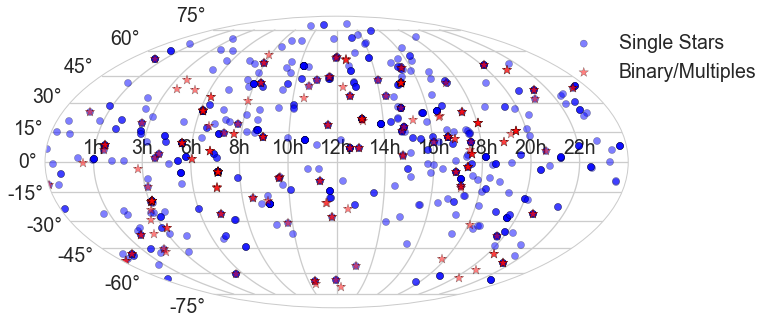

In [90]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="mollweide")
fig.subplots_adjust(right=0.8)

def plot(df, **plot_kws):
    ra = np.array([Angle('{} hours'.format(s)).wrap_at(180*u.deg).radian for s in df.ra])
    dec = np.array([Angle('{} degrees'.format(s)).radian for s in df.dec])

    ax.scatter(ra, dec, **plot_kws)

plot(stats.loc[(stats.known_binary.isnull()) | (stats.known_binary == False)], 
     s=50, label='Single Stars', alpha=0.5)
plot(stats.loc[(stats.known_binary.notnull()) & (stats.known_binary == True)], 
     s=100, c='red', marker='*', label='Binary/Multiples', alpha=0.5)
leg = plt.legend(loc='best', fancybox=True, bbox_to_anchor=(1.25, 1.0))

xticks = Angle(ax.get_xticks() * u.radian) + 180*u.degree
xticks
print(xticks.hourangle)
ax.set_xticklabels(['{}h'.format(int(x)) for x in xticks.hourangle])

fig.savefig('Figures/SkyMap.pdf')

# Make LaTex sample table


In [47]:
# Read in the table and parse some columns
obs = pd.read_csv('data/SampleObservations.csv')

# Make sure the names are right
def standardize_name(starname, head=('HIP', 'ADS', 'HR')):
    if ' ' not in starname:
        for beginning in head:
            if beginning in starname:
                num = starname.split(beginning)[-1]
                return beginning + ' ' + num
        print('Something weird happened with {}'.format(starname))
    return starname

# Standardize by getting the spectral type and ra/dec from simbad
import StarData
def get_spt(starname):
    try:
        data = StarData.GetData(starname)
        return data.spectype
    except:
        return None
    
def get_ra(starname):
    try:
        data = StarData.GetData(starname)
        return data.ra
    except:
        return None
    
def get_dec(starname):
    try:
        data = StarData.GetData(starname)
        return data.dec
    except:
        return None
    
obs['SpT'] = obs.star.map(get_spt)
obs['ra'] = obs.star.map(get_ra)
obs['dec'] = obs.star.map(get_dec)

# make MJD
obs['MJD'] = np.round(obs.jd - 2450000, 2)

# Round the exposure time and snr
obs.exptime = np.round(obs.exptime)
obs.snr = np.round(obs.snr, -1)
obs.star = obs.star.map(standardize_name)

obs.sort_values(by='ra').head()

INFO:root:Getting stellar data for ADS 3962 AB
INFO:root:Getting stellar data for HIP 100221
INFO:root:Getting stellar data for HIP 100907
INFO:root:Getting stellar data for HIP 100907
INFO:root:Getting stellar data for HIP 101123
INFO:root:Getting stellar data for HIP 101909
INFO:root:Getting stellar data for HIP 101909
INFO:root:Getting stellar data for HIP 102487
INFO:root:Getting stellar data for HIP 103298
INFO:root:Getting stellar data for HIP 103298
INFO:root:Getting stellar data for HIP 104105
INFO:root:Getting stellar data for HIP 104365
INFO:root:Getting stellar data for HIP 104365
INFO:root:Getting stellar data for HIP 105891
INFO:root:Getting stellar data for HIP 106786
INFO:root:Getting stellar data for HIP 10732
INFO:root:Getting stellar data for HIP 10732
INFO:root:Getting stellar data for HIP 108339
INFO:root:Getting stellar data for HIP 109056
INFO:root:Getting stellar data for HIP 109056
INFO:root:Getting stellar data for HIP 109056
INFO:root:Getting stellar data for 

,star,ra,dec,date,ut,jd,instrument,exptime,snr,SpT,MJD
471,HIP 813,00:10:2.20,+11:08:44.93,2013-11-22,01:53:23.48,2456618.58197,TS23,557,1810,B9Vn,6618.58
182,HIP 1191,00:14:54.52,-09:34:10.45,2013-09-17,02:08:51.6,2456552.59643,CHIRON,1200,320,B8.5V,6552.60
389,HIP 1366,00:17:5.50,+38:40:53.89,2013-10-20,05:24:55.45,2456585.72723,TS23,274,1790,A2V,6585.73
189,HIP 1647,00:20:39.04,-69:37:29.68,2013-08-06,05:31:09.0,2456510.73636,CHIRON,1105,630,B9V,6510.74
202,HIP 2381,00:30:22.65,-23:47:15.65,2014-08-05,04:57:47.0,2456874.70972,CHIRON,505,580,A3V,6874.71


In [44]:
# Standardize by getting the spectral type and ra/dec from simbad
import StarData
def get_spt(starname):
    try:
        data = StarData.GetData(starname)
        return data.spectype
    except:
        return None
    
def get_ra(starname):
    try:
        data = StarData.GetData(starname)
        return data.ra
    except:
        return None
    
def get_dec(starname):
    try:
        data = StarData.GetData(starname)
        return data.dec
    except:
        return None
    
obs['SpT'] = obs.star.map(get_spt)
obs['ra'] = obs.star.map(get_ra)
obs['dec'] = obs.star.map(get_dec)

INFO:root:Getting stellar data for ADS 3962 AB
INFO:root:Getting stellar data for HIP 100221
INFO:root:Getting stellar data for HIP 100907
INFO:root:Getting stellar data for HIP 100907
INFO:root:Getting stellar data for HIP 101123
INFO:root:Getting stellar data for HIP 101909
INFO:root:Getting stellar data for HIP 101909
INFO:root:Getting stellar data for HIP 102487
INFO:root:Getting stellar data for HIP 103298
INFO:root:Getting stellar data for HIP 103298
INFO:root:Getting stellar data for HIP 104105
INFO:root:Getting stellar data for HIP 104365
INFO:root:Getting stellar data for HIP 104365
INFO:root:Getting stellar data for HIP 105891
INFO:root:Getting stellar data for HIP 106786
INFO:root:Getting stellar data for HIP 10732
INFO:root:Getting stellar data for HIP 10732
INFO:root:Getting stellar data for HIP 108339
INFO:root:Getting stellar data for HIP 109056
INFO:root:Getting stellar data for HIP 109056
INFO:root:Getting stellar data for HIP 109056
INFO:root:Getting stellar data for 

In [45]:
obs.sort_values(by='ra').head()

,star,ra,dec,date,ut,jd,instrument,exptime,snr,MJD,SpT
471,HIP 813,00:10:2.20,+11:08:44.93,2013-11-22,01:53:23.48,2456618.58197,TS23,557,1810,6618.58,B9Vn
182,HIP 1191,00:14:54.52,-09:34:10.45,2013-09-17,02:08:51.6,2456552.59643,CHIRON,1200,320,6552.60,B8.5V
389,HIP 1366,00:17:5.50,+38:40:53.89,2013-10-20,05:24:55.45,2456585.72723,TS23,274,1790,6585.73,A2V
189,HIP 1647,00:20:39.04,-69:37:29.68,2013-08-06,05:31:09.0,2456510.73636,CHIRON,1105,630,6510.74,B9V
202,HIP 2381,00:30:22.65,-23:47:15.65,2014-08-05,04:57:47.0,2456874.70972,CHIRON,505,580,6874.71,A3V


In [46]:
print(obs.sort_values(by='ra').to_latex(columns=('star', 'SpT', 'ra', 'dec', 'MJD', 'instrument', 'exptime', 'snr'), 
                                        index=False, na_rep='\nodata', escape=False, longtable=True))

\begin{longtable}{llllrlrr}
\toprule
        star &            SpT &             ra &            dec &      MJD & instrument &  exptime &     snr \\
\midrule
\endhead
\midrule
\multicolumn{3}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
     HIP 813 &           B9Vn &     00:10:2.20 &   +11:08:44.93 &  6618.58 &       TS23 &      557 &    1810 \\
    HIP 1191 &          B8.5V &    00:14:54.52 &   -09:34:10.45 &  6552.60 &     CHIRON &     1200 &     320 \\
    HIP 1366 &            A2V &     00:17:5.50 &   +38:40:53.89 &  6585.73 &       TS23 &      274 &    1790 \\
    HIP 1647 &            B9V &    00:20:39.04 &   -69:37:29.68 &  6510.74 &     CHIRON &     1105 &     630 \\
    HIP 2381 &            A3V &    00:30:22.65 &   -23:47:15.65 &  6874.71 &     CHIRON &      505 &     580 \\
    HIP 2505 &           B8Vn &    00:31:46.36 &   +54:31:20.23 &  6586.71 &       TS23 &      235 &    1700 \\
    HIP 2505 &           B8Vn &    00:31:46.36 &   +54:31:20

# Compile the primary star best-fit parameters
I will only include those stars for which I detect a companion

In [58]:
# Hard-code this once I have my list finalized!
observed = HelperFunctions.read_observed_targets()
detected_stars = observed.loc[observed.Temperature.notnull(), 'identifier'].unique()
print(detected_stars)

[u'HIP 2548' u'HIP 3478' u'HIP 5310' u'HR 545' u'HR 604' u'HIP 10732'
 u'HIP 12332' u'HIP 12706' u'HIP 13165' u'HIP 13327' u'HIP 14576'
 u'HIP 14764' u'HIP 16244' u'HIP 16340' u'HIP 16611' u'HIP 17563'
 u'HIP 18396' u'HIP 18724' u'HIP 19949' u'HIP 20380' u'HIP 21589'
 u'HIP 22833' u'HIP 22958' u'HIP 23362' u'HIP 23916' u'HIP 24244'
 u'HIP 24902' u'HIP 25143' u'HIP 26063' u'HIP 26126' u'HIP 32607'
 u'HIP 37322' u'HIP 37450' u'HIP 38538' u'HIP 38593' u'HIP 38846'
 u'HIP 39847' u'HIP 40881' u'HIP 42129' u'HIP 46283' u'HIP 51362'
 u'HIP 52678' u'HIP 55266' u'HIP 63945' u'HIP 72154' u'HIP 76267'
 u'HIP 77336' u'HIP 77516' u'HIP 78820' u'HIP 78821' u'HIP 79199'
 u'HIP 79404' u'HIP 80460' u'HIP 82673' u'HIP 84606' u'HIP 85379'
 u'HIP 85998' u'HIP 88116' u'HIP 88818' u'HIP 88817' u'HIP 91118'
 u'HIP 93805' u'HIP 96840' u'HIP 100221' u'HIP 100907' u'HIP 103298'
 u'HIP 109139' u'HIP 109521' u'HIP 115115']


In [101]:
with h5py.File('data/Primary_Parameters.h5', 'r') as f:
    star_list = f.keys()

par_df = pd.read_csv('data/Primary_Parameters.csv')
dh2015_df = pd.read_csv('data/DH2015.csv')

data = defaultdict(list)
for star in detected_stars:
    spt = obs.loc[obs.star == star, 'SpT'].values[0]
    if star.replace(' ', '_') in star_list:
        # Get the mass information
        mass_samples, source = Priors.get_primary_mass(star, spt)
        l, m, h = np.percentile(mass_samples, [16, 50, 84])
        data['star'].append(star)
        data['mass'].append(m)
        data['mass_lowerr'].append(m-l)
        data['mass_higherr'].append(h-m)
        data['source'].append(source)
        
        # Get the age information
        age_samples, _ = Priors.get_ages(star, spt)
        l, m, h = np.percentile(age_samples, [16, 50, 84])
        data['age'].append(m)
        data['age_lowerr'].append(m-l)
        data['age_higherr'].append(h-m)
        
        # Get the temperature, logg, and metallicity that were input to the evolutionary grids
        if source == 'DH2015':
            hipnum = int(star.split('HIP')[-1])
            teff, teff_err, logg, logg_err = dh2015_df.loc[dh2015_df.HIP == hipnum, 
                                                           ['T', 'T_err', 'logg', 'logg_err']].values[0]
        elif source == 'This Study':
            teff, teff_err, logg, logg_err = par_df.loc[par_df.star == star, 
                                                           ['teff', 'teff_err', 'logg', 'logg_err']].values[0]
        else:
            teff, teff_err, logg, logg_err = np.nan, np.nan, np.nan, np.nan
        data['teff'].append(teff)
        data['teff_err'].append(teff_err)
        data['logg'].append(logg)
        data['logg_err'].append(logg_err)
            
        
        
    else:
        print('Star {} not found!'.format(star))
        
    
# Turn into dataframe
summary = pd.DataFrame(data=data)

# Get the RA so we can sort by it
summary = pd.merge(summary, obs[['star', 'ra']], on='star', how='left').drop_duplicates(subset=['star'])

summary.head()

Star HIP 26063 not found!
Star HIP 37322 not found!
Star HIP 37450 not found!
Star HIP 46283 not found!
Star HIP 96840 not found!


,age,age_higherr,age_lowerr,logg,logg_err,mass,mass_higherr,mass_lowerr,source,star,teff,teff_err,ra
0,79.464305,67.955461,53.087945,4.370000,0.14,2.809703,0.158413,0.149726,DH2015,HIP 2548,11864,403,00:32:23.78
2,22.088217,40.099051,15.001857,4.250000,0.25,3.752425,0.499631,0.450097,This Study,HIP 3478,14250,1000,00:44:26.19
6,306.416902,235.979535,196.184290,4.360000,0.14,1.818493,0.095271,0.082819,DH2015,HIP 5310,8611,293,01:07:57.16
7,36.871244,104.846564,28.449881,4.333333,0.25,2.464947,0.392384,0.352698,This Study,HR 545,11000,1000,01:53:31.77
10,28.035246,86.669283,20.402382,4.500000,0.25,2.441881,0.365196,0.338100,This Study,HR 604,11000,1000,02:03:54.72


In [102]:
# LaTexify the values
summary['age_latex'] = summary.apply(lambda row: r'${age:.0f}^{{+{age_higherr:.0f}}}_{{-{age_lowerr:.0f}}}$'.format(**row.to_dict()), axis=1)
summary['mass_latex'] = summary.apply(lambda row: r'${mass:.1f}^{{+{mass_higherr:.2f}}}_{{-{mass_lowerr:.2f}}}$'.format(**row.to_dict()), axis=1)
summary['teff_latex'] = summary.apply(lambda row: r'${teff:.0f} \pm {teff_err:.0f}$'.format(**row.to_dict()), axis=1)
summary['logg_latex'] = summary.apply(lambda row: r'${logg:.1f} \pm {logg_err:.2f}$'.format(**row.to_dict()), axis=1)
summary.head()

,age,age_higherr,age_lowerr,logg,logg_err,mass,mass_higherr,mass_lowerr,source,star,teff,teff_err,ra,age_latex,mass_latex,teff_latex,logg_latex
0,79.464305,67.955461,53.087945,4.370000,0.14,2.809703,0.158413,0.149726,DH2015,HIP 2548,11864,403,00:32:23.78,$79^{+68}_{-53}$,$2.8^{+0.16}_{-0.15}$,$11864 \pm 403$,$4.4 \pm 0.14$
2,22.088217,40.099051,15.001857,4.250000,0.25,3.752425,0.499631,0.450097,This Study,HIP 3478,14250,1000,00:44:26.19,$22^{+40}_{-15}$,$3.8^{+0.50}_{-0.45}$,$14250 \pm 1000$,$4.2 \pm 0.25$
6,306.416902,235.979535,196.184290,4.360000,0.14,1.818493,0.095271,0.082819,DH2015,HIP 5310,8611,293,01:07:57.16,$306^{+236}_{-196}$,$1.8^{+0.10}_{-0.08}$,$8611 \pm 293$,$4.4 \pm 0.14$
7,36.871244,104.846564,28.449881,4.333333,0.25,2.464947,0.392384,0.352698,This Study,HR 545,11000,1000,01:53:31.77,$37^{+105}_{-28}$,$2.5^{+0.39}_{-0.35}$,$11000 \pm 1000$,$4.3 \pm 0.25$
10,28.035246,86.669283,20.402382,4.500000,0.25,2.441881,0.365196,0.338100,This Study,HR 604,11000,1000,02:03:54.72,$28^{+87}_{-20}$,$2.4^{+0.37}_{-0.34}$,$11000 \pm 1000$,$4.5 \pm 0.25$


In [104]:
# Output to table
print(summary.sort_values(by='ra').to_latex(columns=('star', 'teff_latex', 'logg_latex', 'mass_latex', 'age_latex', 'source'), 
                                        index=False, na_rep='\nodata', escape=False, longtable=True))

\begin{longtable}{llllll}
\toprule
       star &        teff_latex &      logg_latex &             mass_latex &            age_latex &      source \\
\midrule
\endhead
\midrule
\multicolumn{3}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
   HIP 2548 &   $11864 \pm 403$ &  $4.4 \pm 0.14$ &  $2.8^{+0.16}_{-0.15}$ &     $79^{+68}_{-53}$ &      DH2015 \\
   HIP 3478 &  $14250 \pm 1000$ &  $4.2 \pm 0.25$ &  $3.8^{+0.50}_{-0.45}$ &     $22^{+40}_{-15}$ &  This Study \\
   HIP 5310 &    $8611 \pm 293$ &  $4.4 \pm 0.14$ &  $1.8^{+0.10}_{-0.08}$ &  $306^{+236}_{-196}$ &      DH2015 \\
     HR 545 &  $11000 \pm 1000$ &  $4.3 \pm 0.25$ &  $2.5^{+0.39}_{-0.35}$ &    $37^{+105}_{-28}$ &  This Study \\
     HR 604 &  $11000 \pm 1000$ &  $4.5 \pm 0.25$ &  $2.4^{+0.37}_{-0.34}$ &     $28^{+87}_{-20}$ &  This Study \\
  HIP 10732 &    $9500 \pm 300$ &  $4.0 \pm 0.25$ &  $2.1^{+0.18}_{-0.16}$ &    $80^{+237}_{-70}$ &  This Study \\
  HIP 12332 &    $7750 \pm 300$ &  $3.5 \

# Compile the companion parameters

In [105]:
companions = pd.read_csv('Corrected_Companion_Data.csv', sep='|').drop_duplicates(subset=['Star'])
companions.head()

,Unnamed: 0,Star,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,[Fe/H],...,Imaging_Detecton,addmode,parsed_date,Tmeas,Tmeas_err,Corrected_Temperature,T_lowerr,T_uperr,Mass,M1
0,0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,HET,20130812,5600,6.985,30,-0.5,...,NaN,simple,2013-08-12,5600.047668,215.998031,5732.020192,111.956254,111.982127,0.999831,2.5
2,2,HIP 3478,B5V,B5V,TS23,20140112,5800,-46.170,5,-0.5,...,NaN,simple,2014-01-12,5799.802745,215.990025,5524.152869,149.773113,149.773877,0.957460,4.6
3,3,HIP 5310,A3V,(A3V + ?; ?),IGRINS,20141014,3400,4.825,30,0.0,...,NaN,simple,2014-10-14,3399.871770,215.846391,3342.732718,154.357141,154.313632,0.352539,2.0
4,4,HR 545,B9.5IV,B9V,IGRINS,20141014,4500,-34.854,5,-0.5,...,NaN,simple,2014-10-14,4499.706320,215.693513,4312.191145,87.255325,87.252411,0.728462,2.5
7,7,HR 604,B8V+A0V,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,TS23,20131020,5000,-4.805,5,0.5,...,NaN,simple,2013-10-20,5000.070687,215.987689,4735.568122,149.777704,149.773948,0.794541,3.4


In [106]:
data = defaultdict(list)
with h5py.File('data/OrbitPrior.h5', 'r') as prior:
    for star in detected_stars:
        spt = obs.loc[obs.star == star, 'SpT'].values[0]
        ra = obs.loc[obs.star == star, 'ra'].values[0]
        if star in prior.keys():
            data['star'].append(star)
            data['ra'].append(ra)
            
            grp = prior[star]
            data['teff'].append(grp.attrs['Corrected_Temperature'])
            data['teff_lowerr'].append(grp.attrs['T_lowerr'])
            data['teff_higherr'].append(grp.attrs['T_uperr'])
            data['vsini'].append(grp.attrs['vsini_sec'])
            data['[Fe/H]'].append(grp.attrs['[Fe/H]'])
            
            # Save summary information for the mass from Dartmouth isochrones
            isomass = grp['companion_isochrone'].value
            l, m, h = np.percentile(isomass, [16, 50, 84])
            data['isomass'].append(m)
            data['isomass_lowerr'].append(m-l)
            data['isomass_higherr'].append(h-m)
            
            # Also save information for spectral type mass
            sptmass = grp['companion_spectral_type'].value
            l, m, h = np.percentile(sptmass, [16, 50, 84])
            data['sptmass'].append(m)
            data['sptmass_lowerr'].append(m-l)
            data['sptmass_higherr'].append(h-m)
            
            
        
        
    else:
        print('Star {} not found!'.format(star))
        
    
# Turn into dataframe
companion_summary = pd.DataFrame(data=data)

companion_summary.head()

Star HIP 115115 not found!


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,[Fe/H],isomass,isomass_higherr,isomass_lowerr,ra,sptmass,sptmass_higherr,sptmass_lowerr,star,teff,teff_higherr,teff_lowerr,vsini
0,-0.5,1.020434,0.055071,0.036741,00:32:23.78,0.999117,0.043543,0.028381,HIP 2548,5732.020192,111.982127,111.956254,30
1,-0.5,1.070724,0.275602,0.126329,00:44:26.19,0.955967,0.032834,0.039750,HIP 3478,5524.152869,149.773877,149.773113,5
2,0.0,0.253527,0.126237,0.084730,01:07:57.16,0.352476,0.119958,0.119343,HIP 5310,3342.732718,154.313632,154.357141,30
3,-0.5,0.766418,0.109664,0.100596,01:53:31.77,0.728057,0.013989,0.019659,HR 545,4312.191145,87.252411,87.255325,5
4,0.5,NaN,NaN,NaN,02:03:54.72,0.794415,0.024367,0.020183,HR 604,4735.568122,149.773948,149.777704,5


In [107]:
# LaTexify the values
companion_summary['isomass_latex'] = companion_summary.apply(lambda row: r'${isomass:.1f}^{{+{isomass_higherr:.2f}}}_{{-{isomass_lowerr:.2f}}}$'.format(**row.to_dict()), axis=1)
companion_summary['sptmass_latex'] = companion_summary.apply(lambda row: r'${sptmass:.1f}^{{+{sptmass_higherr:.2f}}}_{{-{sptmass_lowerr:.2f}}}$'.format(**row.to_dict()), axis=1)
companion_summary['teff_latex'] = companion_summary.apply(lambda row: r'${teff:.0f} \pm {teff_higherr:.0f}$'.format(**row.to_dict()), axis=1)
companion_summary.head()

,[Fe/H],isomass,isomass_higherr,isomass_lowerr,ra,sptmass,sptmass_higherr,sptmass_lowerr,star,teff,teff_higherr,teff_lowerr,vsini,isomass_latex,sptmass_latex,teff_latex
0,-0.5,1.020434,0.055071,0.036741,00:32:23.78,0.999117,0.043543,0.028381,HIP 2548,5732.020192,111.982127,111.956254,30,$1.0^{+0.06}_{-0.04}$,$1.0^{+0.04}_{-0.03}$,$5732 \pm 112$
1,-0.5,1.070724,0.275602,0.126329,00:44:26.19,0.955967,0.032834,0.039750,HIP 3478,5524.152869,149.773877,149.773113,5,$1.1^{+0.28}_{-0.13}$,$1.0^{+0.03}_{-0.04}$,$5524 \pm 150$
2,0.0,0.253527,0.126237,0.084730,01:07:57.16,0.352476,0.119958,0.119343,HIP 5310,3342.732718,154.313632,154.357141,30,$0.3^{+0.13}_{-0.08}$,$0.4^{+0.12}_{-0.12}$,$3343 \pm 154$
3,-0.5,0.766418,0.109664,0.100596,01:53:31.77,0.728057,0.013989,0.019659,HR 545,4312.191145,87.252411,87.255325,5,$0.8^{+0.11}_{-0.10}$,$0.7^{+0.01}_{-0.02}$,$4312 \pm 87$
4,0.5,NaN,NaN,NaN,02:03:54.72,0.794415,0.024367,0.020183,HR 604,4735.568122,149.773948,149.777704,5,$nan^{+nan}_{-nan}$,$0.8^{+0.02}_{-0.02}$,$4736 \pm 150$


In [109]:
# Output to table
print(companion_summary.sort_values(by='ra').to_latex(columns=('star', 'teff_latex', 'vsini', '[Fe/H]', 'isomass_latex', 'sptmass_latex'), 
                                        index=False, na_rep='\\nodata', escape=False, longtable=True))

\begin{longtable}{llrrll}
\toprule
       star &      teff_latex &   vsini &  [Fe/H] &          isomass_latex &          sptmass_latex \\
\midrule
\endhead
\midrule
\multicolumn{3}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
   HIP 2548 &  $5732 \pm 112$ &      30 &    -0.5 &  $1.0^{+0.06}_{-0.04}$ &  $1.0^{+0.04}_{-0.03}$ \\
   HIP 3478 &  $5524 \pm 150$ &       5 &    -0.5 &  $1.1^{+0.28}_{-0.13}$ &  $1.0^{+0.03}_{-0.04}$ \\
   HIP 5310 &  $3343 \pm 154$ &      30 &     0.0 &  $0.3^{+0.13}_{-0.08}$ &  $0.4^{+0.12}_{-0.12}$ \\
     HR 545 &   $4312 \pm 87$ &       5 &    -0.5 &  $0.8^{+0.11}_{-0.10}$ &  $0.7^{+0.01}_{-0.02}$ \\
     HR 604 &  $4736 \pm 150$ &       5 &     0.5 &    $nan^{+nan}_{-nan}$ &  $0.8^{+0.02}_{-0.02}$ \\
  HIP 10732 &  $5578 \pm 109$ &       5 &     0.0 &  $1.0^{+0.29}_{-0.04}$ &  $1.0^{+0.02}_{-0.04}$ \\
  HIP 12332 &  $5551 \pm 107$ &      10 &     0.0 &    $nan^{+nan}_{-nan}$ &  $1.0^{+0.01}_{-0.04}$ \\
  HIP 12706 &  $6051 \